# Import Libraries

In [47]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import sklearn
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
import statsmodels.api as sm
from statsmodels.formula.api import ols
import string
from wordcloud import WordCloud
from ISLP.models import (ModelSpec as MS,
                         summarize)
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.manifold import TSNE

import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")

# special matplotlib argument for improved plots
from matplotlib import rcParams
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/raymondeds/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

# Import Data

In [4]:
df_reviews = pd.read_csv('../data/reviews.csv')
df_submissions = pd.read_csv('../data/Submissions.csv')
df_dec = pd.read_csv('../data/decision.csv')
df_keyword = pd.read_csv('../data/submission_keyword.csv')

# Section 5
* Data Processing
* Rating & Conference Year
* Conference Year vs Number of Submissions
* Submission Length and Paper Decision
* Word Cloud

In [5]:
#data processing
df_rs = pd.merge(df_reviews[['rating_int','confidence_int','review','forum']], df_submissions[['abstract','id','conf_year']], left_on='forum', right_on='id', how = 'inner')
df_rs['review'] = df_rs['review'].str.lower()
df_rs['abstract'] = df_rs['abstract'].str.lower()
df_rs['review_tokens'] = df_rs['review'].apply(word_tokenize)
df_rs['review_num_tokens'] = df_rs['review_tokens'].apply(len)

df_data = pd.merge(df_rs, df_dec, left_on='forum', right_on='forum', how = 'inner').drop([
                                                         'id_x',
                                                         'id_y',
                                                         'tcdate',
                                                         'tmdate',
                                                         'number',
                                                         'confidence'],axis = 1)

In [6]:
df_data.describe()

,rating_int,confidence_int,conf_year,review_num_tokens
count,25168.000000,18434.000000,25168.000000,25168.000000
mean,5.207525,3.741944,2019.824499,497.590273
std,1.760269,0.818314,1.225998,329.276379
min,1.000000,1.000000,2017.000000,3.000000
25%,4.000000,3.000000,2019.000000,280.000000
50%,6.000000,4.000000,2020.000000,419.000000
75%,6.000000,4.000000,2021.000000,626.000000
max,10.000000,5.000000,2021.000000,5716.000000


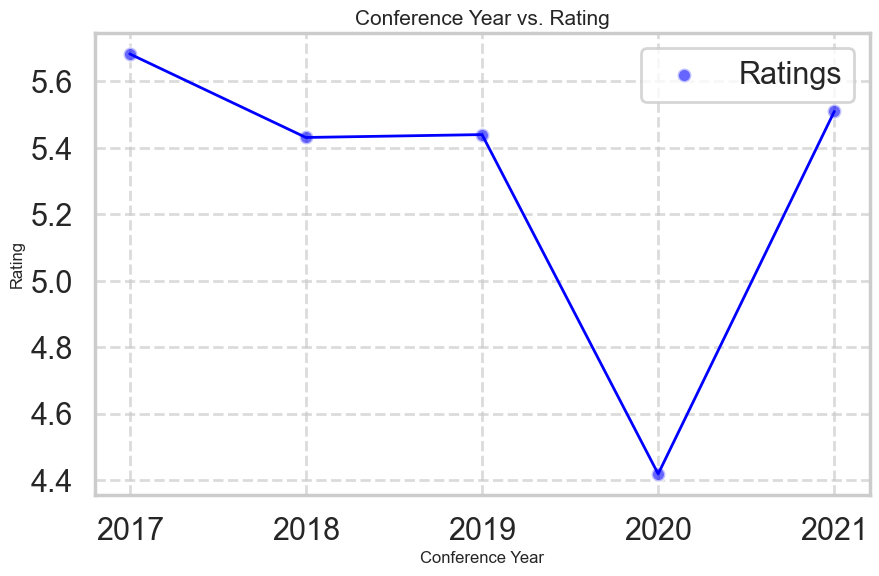

In [8]:
#Getting average review score by submission
df_average_review_score = df_reviews.groupby('forum')['rating_int'].mean()
df_average_review_score = df_average_review_score.reset_index()
df_submission_score = pd.merge(df_submissions, df_average_review_score, left_on='id', right_on='forum', how = 'inner')

df_new = df_submission_score.groupby('conf_year')['rating_int'].mean().reset_index()

# Sort the DataFrame by 'conf_year' if necessary to ensure the line is drawn correctly
df_new_sorted = df_new.sort_values(by='conf_year')

# Create the plot
plt.figure(figsize=(10, 6))

# Scatter plot
plt.scatter(df_new_sorted['conf_year'], df_new_sorted['rating_int'], c='blue', alpha=0.6, edgecolors='w', s=100, label='Ratings')

# Line plot to connect the dots
plt.plot(df_new_sorted['conf_year'], df_new_sorted['rating_int'], color='blue', linewidth=2)

# Add titles and labels
plt.title('Conference Year vs. Rating', fontsize=15)
plt.xlabel('Conference Year', fontsize=12)
plt.ylabel('Rating', fontsize=12)

# Customize the grid
plt.grid(True, linestyle='--', alpha=0.7)

# Add legend
plt.legend()

# Show the plot
plt.show()


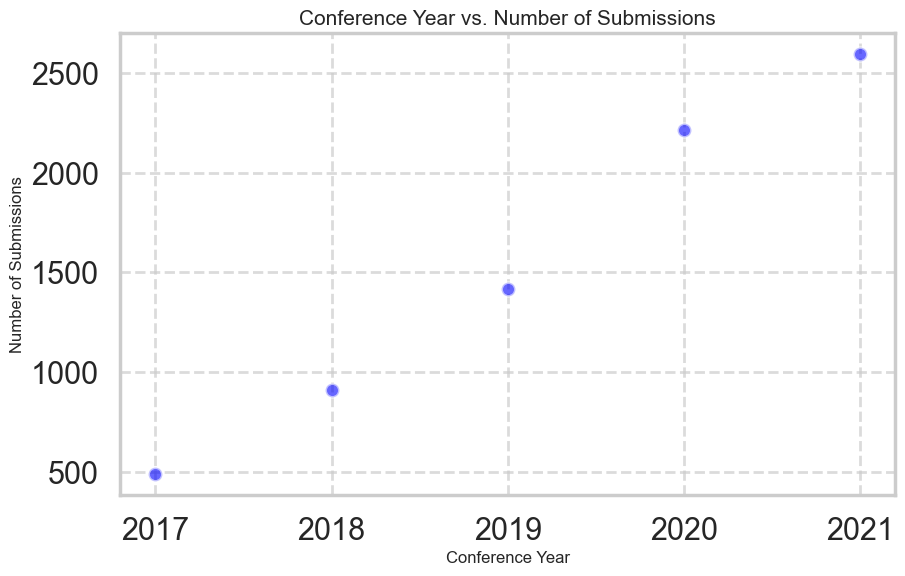

In [9]:
df_submission_count = df_submission_score.groupby('conf_year')['forum'].count().reset_index()


# Customize the scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(df_submission_count['conf_year'], df_submission_count['forum'], c='blue', alpha=0.6, edgecolors='w', s=100)

# Add titles and labels
plt.title('Conference Year vs. Number of Submissions', fontsize=15)
plt.xlabel('Conference Year', fontsize=12)
plt.ylabel('Number of Submissions', fontsize=12)

# Customize the grid
plt.grid(True, linestyle='--', alpha=0.7)

# Add annotations or text if needed (example: highlighting a specific point)
# plt.text(x, y, 'Label', fontsize=12)

# Show the plot
plt.show()

In [15]:
# Removing punctuation
def sentence_count(text):
    return len(sent_tokenize(text))

def clean_up_decision(text):
    if text in ['Accept (Poster)','Accept (Spotlight)', 'Accept (Oral)','Accept (Talk)']:
        return 'Accept'
    else:
        return text

    
df_rev_dec['decision_clean'] = df_rev_dec['decision'].apply(clean_up_decision) 

/opt/anaconda3/envs/nlp/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/anaconda3/envs/nlp/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/anaconda3/envs/nlp/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/anaconda3/envs/nlp/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, Categorica

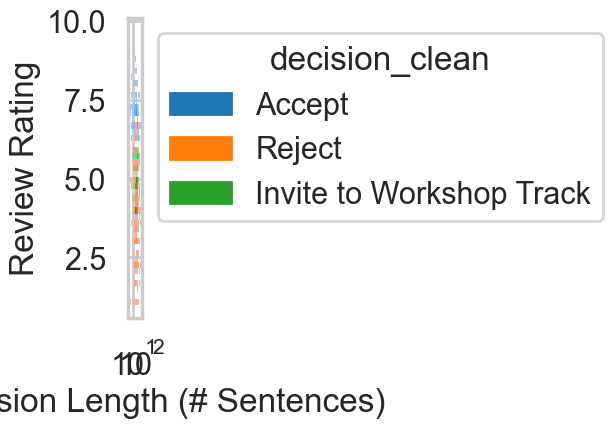

In [25]:


#creating clean review text
df_rev_dec = pd.merge(df_reviews, df_dec, left_on='forum', right_on='forum', how = 'inner')[['review','decision','conf_name_y','rating_int','forum']]
df_rev_dec['sent_count'] = df_rev_dec['review'].apply(sentence_count)
df_rev_dec['clean_review_word'] = df_rev_dec['review'].str.translate(str.maketrans('', '', string.punctuation))


# Tokenizing the text
df_rev_dec['tokens'] = df_rev_dec['clean_review_word'].apply(word_tokenize)


# Removing stop words
stop_words = set(stopwords.words('english'))
df_rev_dec['tokens'] = df_rev_dec['tokens'].apply(lambda x: [word for word in x if word not in stop_words])
df_rev_dec['tokens_counts'] = df_rev_dec['tokens'].apply(len)

#cleaning up decision labels
df_rev_dec['decision_clean'] = df_rev_dec['decision'].apply(clean_up_decision) 
df_rev_dec_ave = df_rev_dec.groupby(['forum','decision_clean'])[['rating_int','tokens_counts','sent_count']].mean().reset_index()


/opt/anaconda3/envs/nlp/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/anaconda3/envs/nlp/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/anaconda3/envs/nlp/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/anaconda3/envs/nlp/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, Categorica

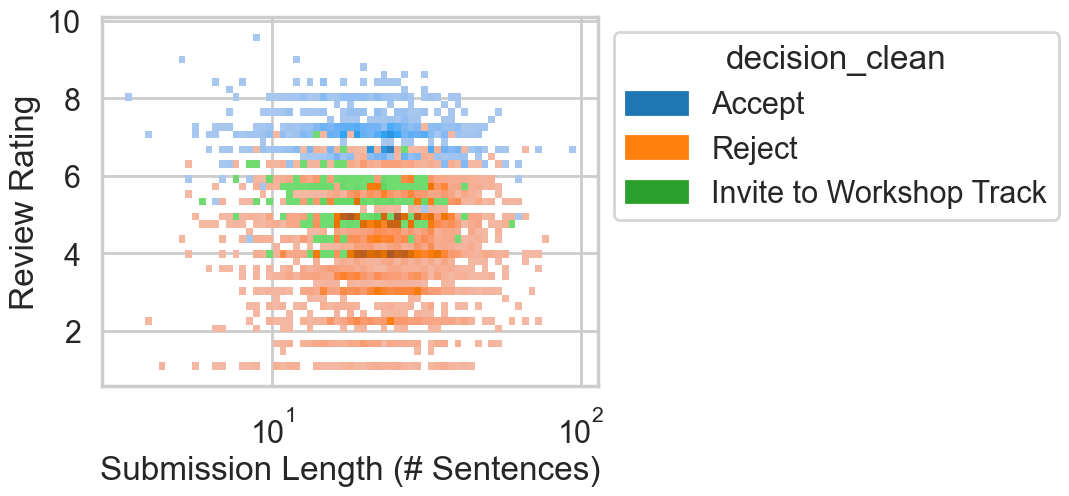

In [27]:
ax = sns.histplot(data=df_rev_dec_ave, x='sent_count',
                  y='rating_int',
                  hue='decision_clean',
                kde=True, 
                  log_scale=(True,False),
                 legend=True)

# Set axis labels
ax.set(xlabel='Submission Length (# Sentences)', ylabel='Review Rating')

# Move the legend outside the plot
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))


plt.show()

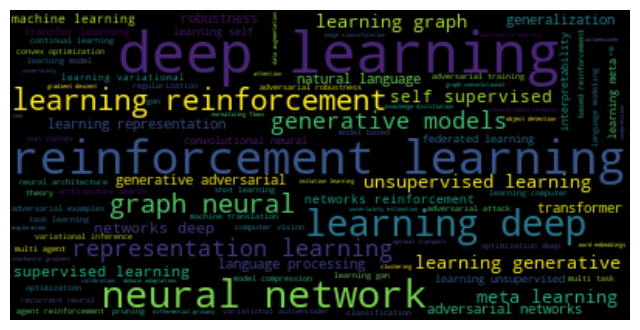

In [31]:
# Concatenate text data
text = ' '.join(df_keyword['primary_keyword'])

# Generate word cloud
wordcloud = WordCloud().generate(text)

# Display word cloud
plt.figure(figsize=(8, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

# Section 6
* 6.1 Correlation Matrix

In [28]:
df_data.corr(numeric_only=True)

,rating_int,confidence_int,conf_year,review_num_tokens
rating_int,1.000000,-0.143676,-0.025562,-0.051541
confidence_int,-0.143676,1.000000,-0.047991,0.144216
conf_year,-0.025562,-0.047991,1.000000,0.186834
review_num_tokens,-0.051541,0.144216,0.186834,1.000000


# Section 7
* Table 2
* Figure 1

* Table

In [34]:
def regression_graph(y,x,df,title):

    # Set the aesthetic style of the plots
    sns.set(style="whitegrid")

    # Create a regression plot
    plt.figure(figsize=(10, 6))
    sns.regplot(y=y, x=x, data=df, fit_reg=True, 
                scatter_kws={'s': 50, 'alpha': 0.6, 'color': 'b'}, 
                line_kws={'color': 'red', 'linewidth': 2})

    # Customize the plot with titles and labels
    plt.title(title, fontsize=20)

    # Customize the ticks on the axes
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)

    # Show grid
    plt.grid(True, linestyle='--', alpha=0.7)

    # Show the plot
    plt.show()

In [35]:
m = ols('rating_int ~ confidence_int',df_data).fit()
m.summary()

/opt/anaconda3/envs/nlp/lib/python3.10/site-packages/patsy/util.py:672: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return _pandas_is_categorical_dtype(dt)
/opt/anaconda3/envs/nlp/lib/python3.10/site-packages/patsy/util.py:672: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return _pandas_is_categorical_dtype(dt)
/opt/anaconda3/envs/nlp/lib/python3.10/site-packages/patsy/util.py:672: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return _pandas_is_categorical_dtype(dt)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             rating_int   R-squared:                       0.021
Model:                            OLS   Adj. R-squared:                  0.021
Method:                 Least Squares   F-statistic:                     388.5
Date:                Thu, 08 Aug 2024   Prob (F-statistic):           1.33e-85
Time:                        21:58:42   Log-Likelihood:                -32995.
No. Observations:               18434   AIC:                         6.599e+04
Df Residuals:                   18432   BIC:                         6.601e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          6.4568      0.050    129.232      0.000       6.359       6.555
confidence_int    -0.2571      0.013    -19.711      0.000      -0.283      -0.232
==============================================================================
Omnibus:                      107.019   Durbin-Watson:                   1.409
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               76.570
Skew:                           0.028   Prob(JB):                     2.36e-17
Kurtosis:                       2.689   Cond. No.                         19.1
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

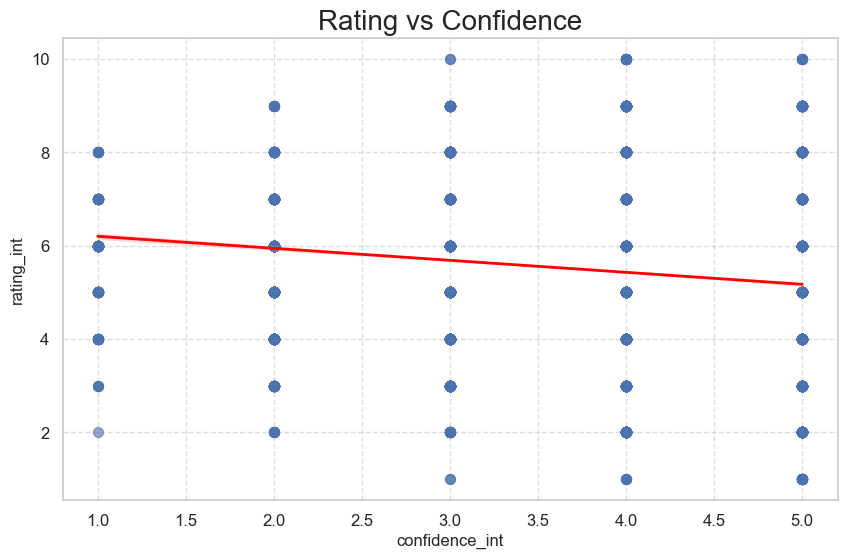

In [36]:
regression_graph('rating_int','confidence_int',df_data,'Rating vs Confidence')

In [38]:
m = ols('review_num_tokens ~ rating_int',df_data).fit()
m.summary()

/opt/anaconda3/envs/nlp/lib/python3.10/site-packages/patsy/util.py:672: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return _pandas_is_categorical_dtype(dt)
/opt/anaconda3/envs/nlp/lib/python3.10/site-packages/patsy/util.py:672: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return _pandas_is_categorical_dtype(dt)
/opt/anaconda3/envs/nlp/lib/python3.10/site-packages/patsy/util.py:672: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return _pandas_is_categorical_dtype(dt)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      review_num_tokens   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     67.03
Date:                Thu, 08 Aug 2024   Prob (F-statistic):           2.80e-16
Time:                        22:02:14   Log-Likelihood:            -1.8157e+05
No. Observations:               25168   AIC:                         3.632e+05
Df Residuals:                   25166   BIC:                         3.632e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    547.7972      6.473     84.625      0.000     535.109     560.485
rating_int    -9.6412      1.178     -8.187      0.000     -11.949      -7.333
==============================================================================
Omnibus:                    15300.862   Durbin-Watson:                   1.832
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           284919.811
Skew:                           2.588   Prob(JB):                         0.00
Kurtosis:                      18.649   Cond. No.                         17.7
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

/opt/anaconda3/envs/nlp/lib/python3.10/site-packages/patsy/util.py:672: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return _pandas_is_categorical_dtype(dt)
/opt/anaconda3/envs/nlp/lib/python3.10/site-packages/patsy/util.py:672: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return _pandas_is_categorical_dtype(dt)
/opt/anaconda3/envs/nlp/lib/python3.10/site-packages/patsy/util.py:672: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return _pandas_is_categorical_dtype(dt)


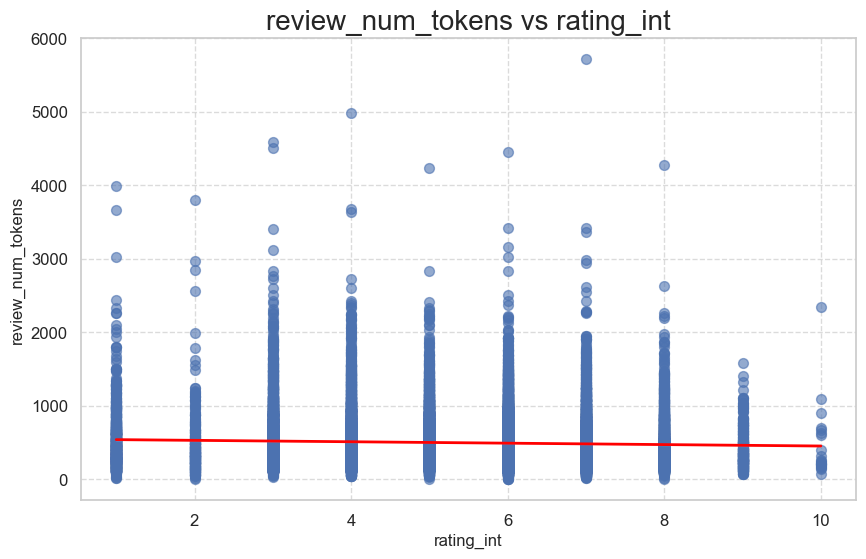

In [37]:
regression_graph('review_num_tokens','rating_int',df_data,'review_num_tokens vs rating_int')

In [40]:
m = ols('review_num_tokens ~ confidence_int',df_data).fit()
m.summary()

/opt/anaconda3/envs/nlp/lib/python3.10/site-packages/patsy/util.py:672: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return _pandas_is_categorical_dtype(dt)
/opt/anaconda3/envs/nlp/lib/python3.10/site-packages/patsy/util.py:672: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return _pandas_is_categorical_dtype(dt)
/opt/anaconda3/envs/nlp/lib/python3.10/site-packages/patsy/util.py:672: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return _pandas_is_categorical_dtype(dt)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      review_num_tokens   R-squared:                       0.021
Model:                            OLS   Adj. R-squared:                  0.021
Method:                 Least Squares   F-statistic:                     391.5
Date:                Thu, 08 Aug 2024   Prob (F-statistic):           3.07e-86
Time:                        22:02:35   Log-Likelihood:            -1.3306e+05
No. Observations:               18434   AIC:                         2.661e+05
Df Residuals:                   18432   BIC:                         2.661e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept        285.2396     11.381     25.062      0.000     262.931     307.548
confidence_int    58.7917      2.971     19.786      0.000      52.968      64.616
==============================================================================
Omnibus:                    11037.147   Durbin-Watson:                   1.800
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           199232.402
Skew:                           2.542   Prob(JB):                         0.00
Kurtosis:                      18.282   Cond. No.                         19.1
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

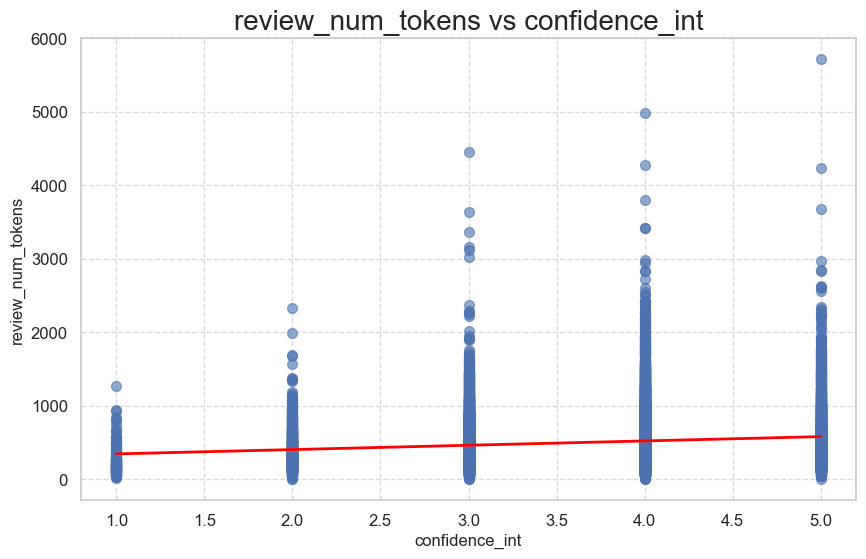

In [39]:
regression_graph('review_num_tokens','confidence_int',df_data,'review_num_tokens vs confidence_int')

In [44]:
allvars = df_data[['rating_int', 'conf_year']]
design = MS(allvars)
X = design.fit_transform(allvars).astype(float)
y = df_data.decision == 'Reject'
glm = sm.GLM(y,
             X,
             family=sm.families.Binomial())
results = glm.fit()
summarize(results)

,coef,std err,z,P>|z|
intercept,-404.0363,25.160,-16.059,0.0
rating_int,-0.9376,0.013,-70.338,0.0
conf_year,0.2029,0.012,16.286,0.0


/opt/anaconda3/envs/nlp/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/anaconda3/envs/nlp/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/anaconda3/envs/nlp/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/anaconda3/envs/nlp/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, Categorica

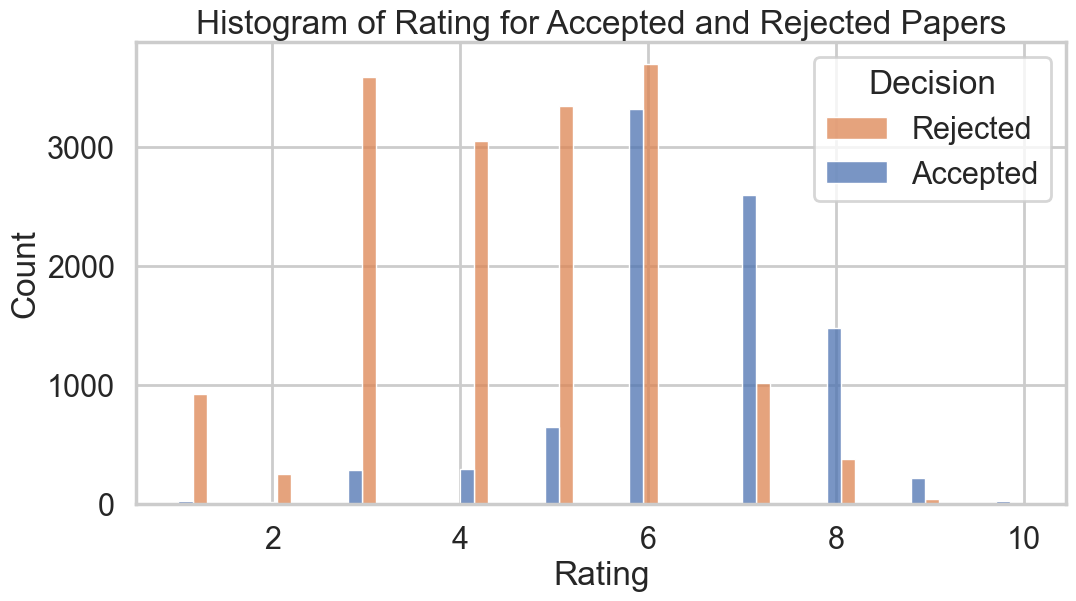

In [45]:
# Convert the decision column to a numeric column for easier handling
df_data['decision_numeric'] = df_data['decision'].apply(lambda x: 1 if x == 'Reject' else 0)

# Create a histogram for the rating grouped by decision
plt.figure(figsize=(12, 6))
sns.histplot(data=df_data, x='rating_int', hue='decision_numeric', multiple='dodge', bins=30)
plt.xlabel('Rating')
plt.ylabel('Count')
plt.title('Histogram of Rating for Accepted and Rejected Papers')
plt.legend(title='Decision', labels=['Rejected', 'Accepted'])
plt.show()


/opt/anaconda3/envs/nlp/lib/python3.10/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/opt/anaconda3/envs/nlp/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/nlp/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/nlp/lib/python3.10/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinsta

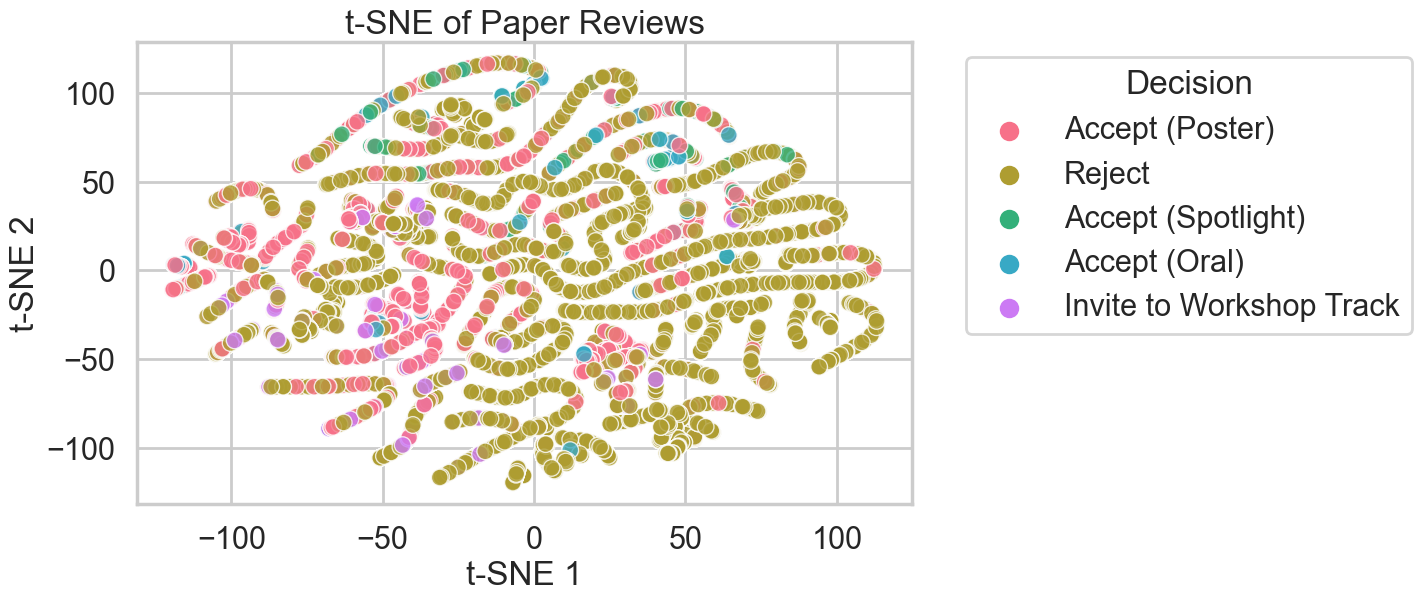

In [48]:

# Convert categorical variable 'decision' to numerical
le = LabelEncoder()
df_data['decision_num'] = le.fit_transform(df_data['decision'])
df_data = df_data.dropna()

# Features to be used in t-SNE
features = ['rating_int', 'conf_year', 'review_num_tokens', 'confidence_int']
X = df_data[features].dropna()

# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply t-SNE
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X_scaled)

# Add t-SNE results to the DataFrame
df_data['tsne-2d-one'] = X_tsne[:, 0]
df_data['tsne-2d-two'] = X_tsne[:, 1]

# Define a custom color palette with 5 colors
custom_palette = sns.color_palette('husl', 5)

# Plot t-SNE results
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x='tsne-2d-one', y='tsne-2d-two',
    hue='decision',
    palette=custom_palette,
    data=df_data,
    alpha=0.8
)
plt.title('t-SNE of Paper Reviews')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.legend(title='Decision', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

# Supplmental Deep Learning w/ RoBERTa

Not implemented due to resource limitations

In [55]:
from transformers import pipeline
from transformers import AutoTokenizer

# Step 3: Load the pre-trained model and tokenizer
sentiment_analysis = pipeline("sentiment-analysis", model="cardiffnlp/twitter-roberta-base-sentiment-latest")
tokenizer = AutoTokenizer.from_pretrained("cardiffnlp/twitter-roberta-base-sentiment-latest")

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [58]:

# Define a function to split the text into chunks
def split_text_into_chunks(text, tokenizer, max_length):
    tokens = tokenizer.tokenize(text)
    chunks = []
    current_chunk = []
    current_length = 0

    for token in tokens:
        if current_length + len(token) > max_length:
            chunks.append(" ".join(current_chunk))
            current_chunk = []
            current_length = 0
        current_chunk.append(token)
        current_length += len(token)
    
    if current_chunk:
        chunks.append(" ".join(current_chunk))
    
    return chunks

# Define a function to perform sentiment analysis on the entire text
def analyze_sentiment(text, tokenizer, sentiment_analysis, max_length):
    chunks = split_text_into_chunks(text, tokenizer, max_length)
    results = []
    
    for chunk in chunks:
        result = sentiment_analysis(chunk)
        results.extend(result)
    
    return results

# Example usage
text = "Your long text goes here..."

# The max_length for the tokenizer
max_length = 514

# Perform sentiment analysis on the long text
#sentiment_results = analyze_sentiment(df_data.review[0], tokenizer, sentiment_analysis, max_length)

# Print the results
def ave_sent(sent_results):
    
    l_sent = []
    for i, result in enumerate(sent_results):
        
        l_sent.append(result['score'])
    
    return sum(l_sent)/len(l_sent)

def get_sentiment_result(text):
    sentiment_results = analyze_sentiment(text, tokenizer, sentiment_analysis, max_length=514)
    ave_sent_result = ave_sent(sentiment_results)

    return ave_sent_result

In [59]:
#average sentiment of a single review text
get_sentiment_result(df_data['review'][0])

0.7308477679888408

In [60]:
#data provided by Zhang Et Al.
df_sent = pd.read_csv('../data/submission_sentiment.csv')
df_data_sent = pd.merge(df_data, df_sent, left_on='forum', right_on='submission_id', how = 'inner')


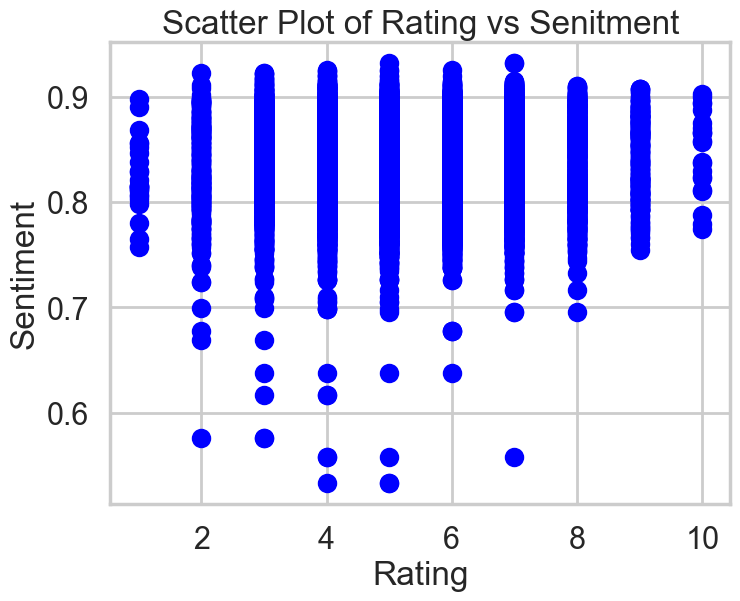

In [61]:
plt.figure(figsize=(8, 6))
plt.scatter(df_data_sent['rating_int'], df_data_sent['mean_sentiment'], color='blue', marker='o')

# Add title and labels
plt.title('Scatter Plot of Rating vs Senitment')
plt.xlabel('Rating')
plt.ylabel('Sentiment')

# Show plot
plt.grid(True)